## 05 – Model evaluation and out-of-sample performance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pd.set_option("display.float_format", lambda x: f"{x:.6f}")

project_root = Path("..")

data_dir = project_root / "data"
outputs_dir = project_root / "outputs"
plots_dir = outputs_dir / "plots"
results_dir = outputs_dir / "results"

error_hist_dir = plots_dir / "error_hist"
true_vs_pred_dir = plots_dir / "true_vs_pred"

plots_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)
error_hist_dir.mkdir(parents=True, exist_ok=True)
true_vs_pred_dir.mkdir(parents=True, exist_ok=True)

In [2]:
y_test = pd.read_parquet(results_dir / "y_test_targets.parquet")
y_pred_naive = pd.read_parquet(results_dir / "y_pred_naive.parquet")
y_pred_linreg = pd.read_parquet(results_dir / "y_pred_linreg.parquet")
y_pred_rf = pd.read_parquet(results_dir / "y_pred_rf.parquet")

preds = {
    "naive": y_pred_naive,
    "linreg": y_pred_linreg,
    "rf": y_pred_rf,
}

for name, y_pred in preds.items():
    y_pred_aligned = y_pred.reindex(y_test.index)
    if y_pred_aligned.isna().any().any():
        raise ValueError(f"{name}: predictions do not align with y_test index (missing rows after reindex).")
    preds[name] = y_pred_aligned

y_pred_naive = preds["naive"]
y_pred_linreg = preds["linreg"]
y_pred_rf = preds["rf"]

In [3]:
def compute_metrics(y_true: pd.Series, y_pred: pd.Series) -> dict[str, float]:
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
    }

In [4]:
model_predictions = {
    "naive": y_pred_naive,
    "linreg": y_pred_linreg,
    "rf": y_pred_rf,
}

for name, df_pred in model_predictions.items():
    if list(df_pred.columns) != list(y_test.columns):
        raise ValueError(f"{name}: prediction columns do not match y_test columns.")

rows = []
for target in y_test.columns:
    y_true = y_test[target]
    for model_name, df_pred in model_predictions.items():
        m = compute_metrics(y_true, df_pred[target])
        m["target"] = target
        m["model"] = model_name
        rows.append(m)

metrics_df = pd.DataFrame(rows)[["target", "model", "RMSE", "MAE", "R2"]]
metrics_df = metrics_df.sort_values(["target", "model"]).reset_index(drop=True)

metrics_df

,target,model,RMSE,MAE,R2
0,ICLN_target,linreg,0.016351,0.012443,-0.057151
1,ICLN_target,naive,0.015938,0.012119,-0.004429
2,ICLN_target,rf,0.016238,0.012232,-0.042621
3,XLE_target,linreg,0.012148,0.009587,-0.096209
4,XLE_target,naive,0.011603,0.008957,-0.000002
5,XLE_target,rf,0.012588,0.009593,-0.176936


In [14]:
metrics_csv_path = results_dir / "model_performance_metrics.csv"
metrics_df.to_csv(metrics_csv_path, index=False)

metrics_csv_path

PosixPath('../outputs/results/model_performance_metrics.csv')

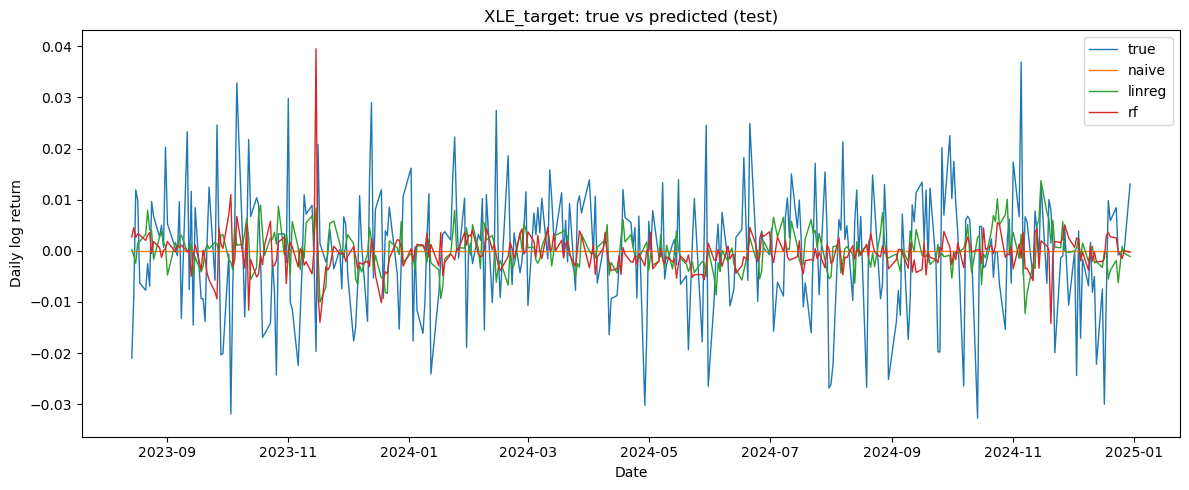

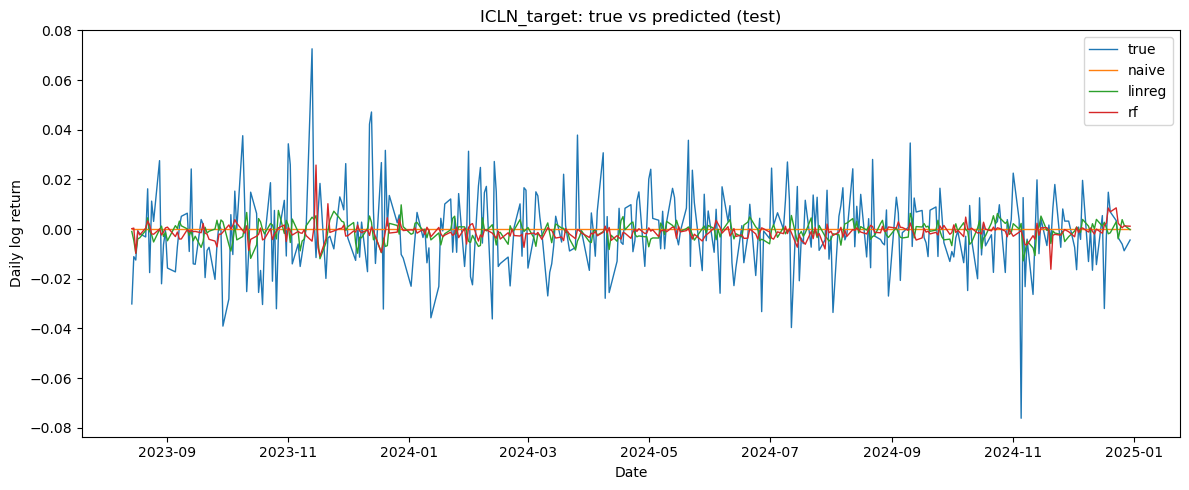

In [6]:
for target in y_test.columns:
    fig, ax = plt.subplots(figsize=(12, 5))

    ax.plot(y_test.index, y_test[target], label="true", linewidth=1)

    for model_name, df_pred in model_predictions.items():
        ax.plot(y_test.index, df_pred[target], label=model_name, linewidth=1)

    ax.set_title(f"{target}: true vs predicted (test)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Daily log return")
    ax.legend()

    fig.tight_layout()
    fig.savefig(true_vs_pred_dir / f"true_vs_pred_{target}.png", dpi=150)
    plt.show()

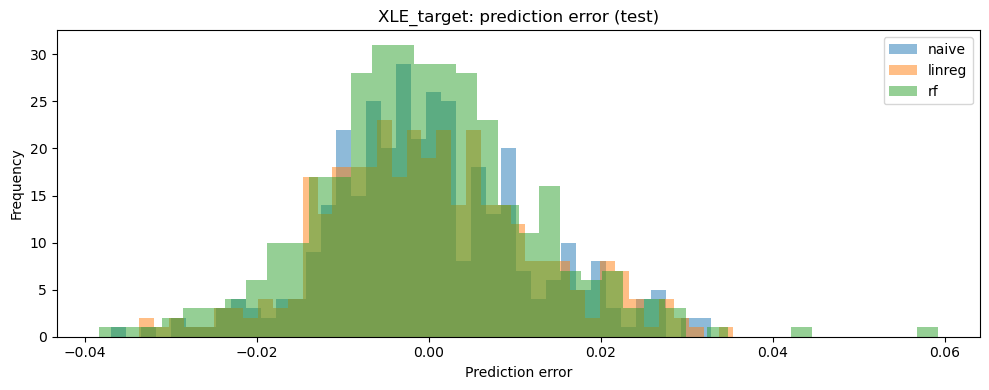

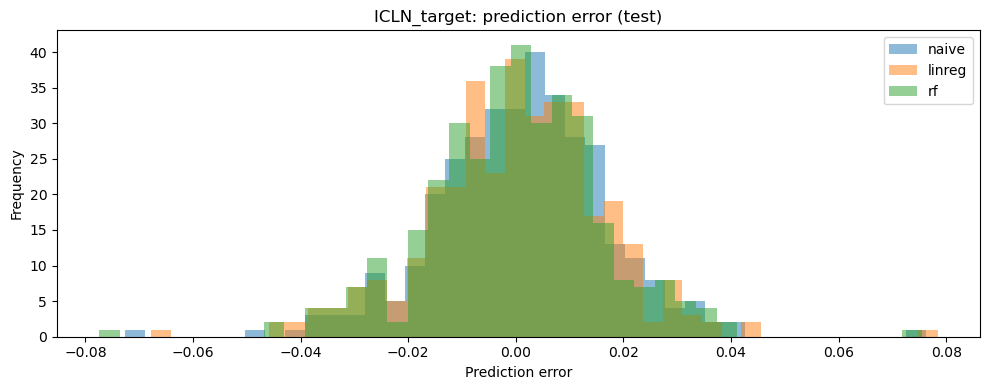

In [7]:
for target in y_test.columns:
    fig, ax = plt.subplots(figsize=(10, 4))

    for model_name, df_pred in model_predictions.items():
        err = df_pred[target] - y_test[target]
        ax.hist(err, bins=40, alpha=0.5, label=model_name)

    ax.set_title(f"{target}: prediction error (test)")
    ax.set_xlabel("Prediction error")
    ax.set_ylabel("Frequency")
    ax.legend()

    fig.tight_layout()
    fig.savefig(error_hist_dir / f"error_hist_{target}.png", dpi=150)
    plt.show()

## Interpretation (based on out-of-sample metrics)

Model ranking is based on test-set RMSE, reported in model_performance_metrics.csv

Key limitations are methodological: daily data, a single feature set driven by WTI-derived predictors, and potential regime changes (e.g., COVID-19, 2022 energy shock).